In [0]:
from lib import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.chdir("..")

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

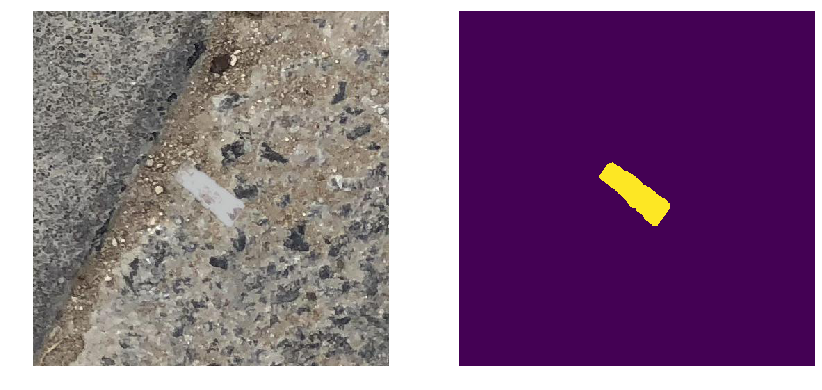

Размеры изображения 512 * 512 
 Размерность тензора на основе изображения для входных данных в нейронную сеть (512, 512, 3) 
 Количество изображений для обучения 2000


In [26]:
# Рассмотрим каталог с данными для обучения
path_train = "/data/train/"
images_train = os.listdir(f"{path_train}/images")
annotations_train = json.load(open(f"{path_train}/coco_annotations.json", "r"))

img_id = int(np.random.choice(images_train).split(".")[0])

img = np.array(Image.open(f"{path_train}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations_train)
show_img_with_mask(img, mask)

img_width, img_height = img.shape[:2]
input_shape = img.shape
nb_train_samples = len(images_train)
print('Размеры изображения', img_width,'*',img_height, '\n',\
     'Размерность тензора на основе изображения для входных данных в нейронную сеть', img.shape,'\n',\
     'Количество изображений для обучения', nb_train_samples)

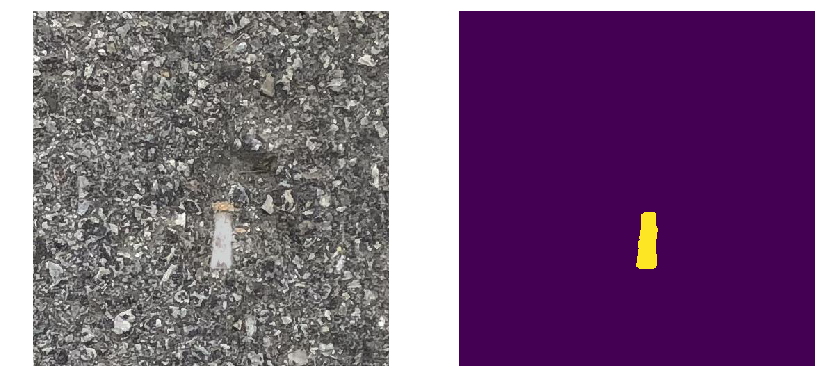

In [7]:
# Создим таблицу для train со столбцами «имя изображения», «маска»
rle_mask = []
for i in images_train:
    current = int(i.split(".")[0])
    rle_mask.append(encode_rle(get_mask(current, annotations_train)))
    
train = pd.DataFrame({'img_name' : images_train, 'rle_mask' : rle_mask}, columns=['img_name', 'rle_mask'])

i = 155
show_img_with_mask(np.array(Image.open(f"{path_train}/images/{train.img_name[i]}")), decode_rle(train.rle_mask[i]))

In [8]:
# Каталог с данными для валидации
path_val = "/data/val/"
images_val = os.listdir(f"{path_val}/images/")
annotations_val = json.load(open(f"{path_val}/coco_annotations.json", "r"))

# Создим таблицу для val со столбцами «имя изображения», «маска»
rle_mask_val = []
for i in images_val:
    current = int(i.split(".")[0])
    rle_mask_val.append(encode_rle(get_mask(current, annotations_val)))
    
val = {'img_name' : images_val, 'rle_mask' : rle_mask_val}
val = pd.DataFrame(val, columns=['img_name', 'rle_mask'])

nb_validation_samples = len(val)
print('Размеры изображения', mask.shape[0],'*',mask.shape[1], '\n',\
     'Размерность тензора на основе масок', mask.shape, '\n',
     'Количество изображений для валидации', nb_validation_samples)

Размеры изображения 512 * 512 
 Размерность тензора на основе масок (512, 512) 
 Количество изображений для валидации 200


In [9]:
# Каталог с данными для тестирования
path_test = "/data/real_test/"
images_test = os.listdir(f"{path_test}")
i = 4
img = np.array(Image.open(f"{path_test}{images_test[i]}"))
nb_test_samples = 10
print('Размерность тензора на основе тестовых изображений', img.shape, '\n',\
     'Количество изображений для тестирования',nb_test_samples)

Размерность тензора на основе тестовых изображений (512, 512, 3) 
 Количество изображений для тестирования 10


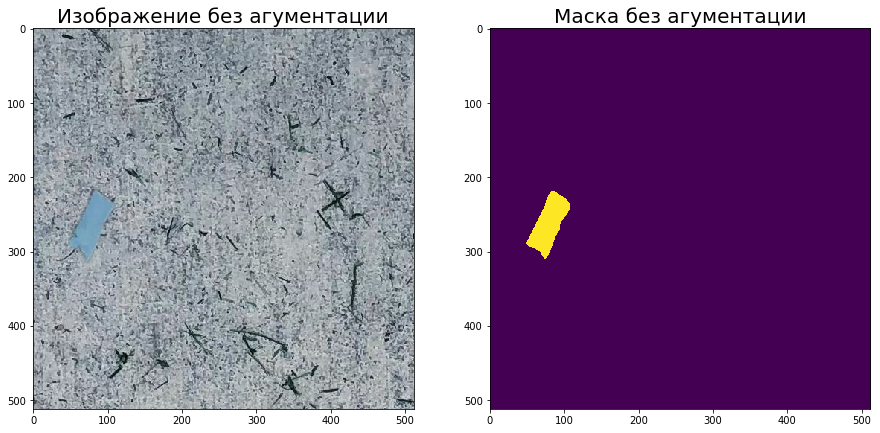

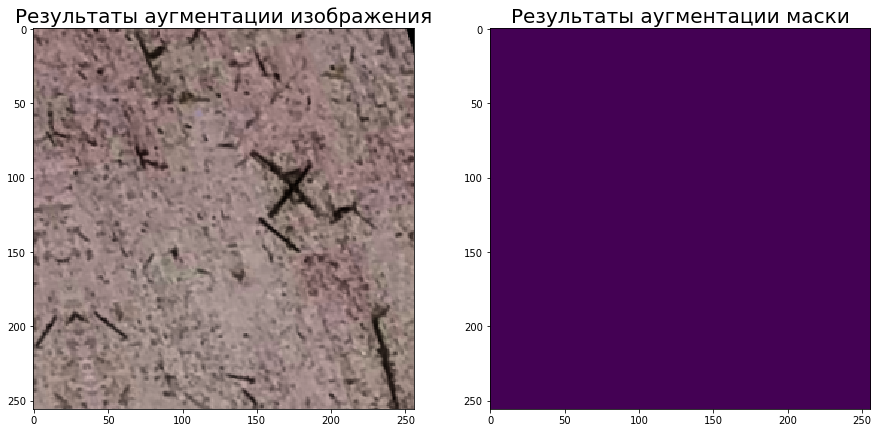

In [86]:
'''Дополнение данных для обучения глубоких нейросетей (data augmentation)'''

from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout,
    PadIfNeeded,HorizontalFlip, VerticalFlip,CenterCrop, Crop, Compose, Transpose, ElasticTransform, 
    GridDistortion, OpticalDistortion,RandomSizedCrop, OneOf, CLAHE, RandomBrightnessContrast,RandomGamma 
)

'''Параметры аугментации'''
def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        #HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),     
    ],
        p=p)

i = 18
image_file_name = train.img_name[i]
img = cv2.imread(f"{path_train}images/{image_file_name}")
img_id = int((image_file_name).split(".")[0])
mask = get_mask(img_id, annotations_train)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(img)
axes[1].imshow(mask)
axes[0].set_title('Изображение без агументации', fontsize = 20)
axes[1].set_title('Маска без агументации', fontsize = 20)

augmentation = strong_aug(p=1.0)

data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[0].set_title('Результаты аугментации изображения', fontsize = 20)
axes[1].set_title('Результаты аугментации маски', fontsize = 20)
axes[1].imshow(crop_mask)
plt.show()

In [ ]:
# Аугментация набора данных train + добавить к train, val изображения и маски из augmented/

path_augmented = "/{path_train}/augmented/"
for i in range(0,len(val)):
    img = np.array(Image.open(f"{path_train}/images/{val.iloc[i][0]}"))
    mask = val.rle_mask.iloc[[i]].values
    data = {'image': img.astype('uint8'), 'mask': mask}
    augmented = augmentation(**data)
    new_img, new_mask = augmented["image"], augmented["mask"]
    new_image_path = "%s/augmente_image_%s.jpg" %(path_augmented, i)
    cv2.imwrite(new_image_path,  new_img)

    new_mask_path = "%s/augmente_mask_%s.jpg" %(path_augmented, i)
    cv2.imwrite(new_mask_path,  new_mask)



In [112]:
"""Функция генерирует подвыборки из data размера batch_size"""
def keras_generator(data, batch_size, current_path):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = data.sample(1).values[0]

            img = np.array(Image.open(f"{current_path}images/{img_name}"))
            #img = cv2.imread('f"{current_path}images/{}'.format(img_name))
            mask = decode_rle(mask_rle)
            
#             img = cv2.resize(img, (256, 256))
#             mask = cv2.resize(mask, (256, 256))
                      
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)
        
for imgs_train, msks_train in keras_generator(train, 16, path_train):
    break
    
for imgs_val, msks_val in keras_generator(val, 16, path_val):
    break

In [ ]:
# модели для сегментации были выбраны из https://github.com/divamgupta/image-segmentation-keras, 
# https://github.com/meetshah1995/pytorch-semseg, LINKNET https://github.com/e-lab/LinkNet
# RetinaNet https://github.com/kuangliu/pytorch-retinanet
# WNET https://github.com/taoroalin/WNet/blob/master/WNet.py

In [114]:
'''Компилируем сеть U-Net' c логлоссом dice_coef_loss и метрикой dice_coef'''

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input((512, 512, 3))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
# optimizer='SGD',loss=sm.losses.jaccard_loss, loss="categorical_crossentropy"
# model.summary()

In [ ]:
'''Остановка обучения нейросети при переобучении'''
callbacks = [
    EarlyStopping(patience=10, verbose=1), # patience=3
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
# checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)    
]

'''Обучаем нейронную сеть'''
history = model.fit_generator(keras_generator(train, 16, path_train),
              steps_per_epoch=100,
              epochs=25,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val, 16, path_val),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

"""Визуализируем историю обучения сети"""
# print(history.history.keys())
plt.plot(history.history['acc'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

print("Обучение остановлено на эпохе", early_stopping_callback.stopped_epoch)

Epoch 1/25
100/100 [==============================] - 106s 1s/step - loss: -0.9301 - dice_coef: 0.9301 - val_loss: -0.9018 - val_dice_coef: 0.9174
Epoch 2/25
100/100 [==============================] - 93s 932ms/step - loss: -1.0419 - dice_coef: 1.0419 - val_loss: -0.9914 - val_dice_coef: 0.9826
Epoch 3/25
 99/100 [============================>.] - ETA: 0s - loss: -1.2200 - dice_coef: 1.2200

In [ ]:
'''Сохраняем нейронную сеть для последующего использования'''
model.save('unet.h5')

In [ ]:

import math
import torch
import torch.nn as nn
import torch.nn.init as init

from fpn import FPN50
from retinanet import RetinaNet


print('Loading pretrained ResNet50 model..')
d = torch.load('./model/resnet50.pth')

print('Loading into FPN50..')
fpn = FPN50()
dd = fpn.state_dict()
for k in d.keys():
    if not k.startswith('fc'):  # skip fc layers
        dd[k] = d[k]

print('Saving RetinaNet..')
net = RetinaNet()
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        init.normal(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant(net.cls_head[-1].bias, -math.log((1-pi)/pi))

net.fpn.load_state_dict(dd)
torch.save(net.state_dict(), 'net.pth')

net.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
'''Остановка обучения нейросети при переобучении'''
callbacks = [
    EarlyStopping(patience=10, verbose=1), # patience=3
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
# checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)    
]

'''Обучаем нейронную сеть'''
history = model.fit_generator(keras_generator(train, 16, path_train),
              steps_per_epoch=100,
              epochs=25,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val, 16, path_val),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

"""Визуализируем историю обучения сети"""
# print(history.history.keys())
plt.plot(history.history['acc'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

print("Обучение остановлено на эпохе", early_stopping_callback.stopped_epoch)

In [ ]:
'''Оптимизация гиперпараметров нейросети'''

!git clone https://github.com/keras-team/keras-tuner.git
!cd keras-tuner
!pip install .

import kerastuner as kt
import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

def build_model(hp):
  model_type = hp.Choice('model_type', ['random_forest', 'ridge'])
  if model_type == 'random_forest':
    model = ensemble.RandomForestClassifier(
        n_estimators=hp.Int('n_estimators', 10, 50, step=10),
        max_depth=hp.Int('max_depth', 3, 10))
  else:
    model = linear_model.RidgeClassifier(
        alpha=hp.Float('alpha', 1e-3, 1, sampling='log'))
  return model

tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=10),
    hypermodel=build_model,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=model_selection.StratifiedKFold(5),
    directory='.',
    project_name='my_project')


tuner.search(keras_generator(train, 16, path_train))

best_model = tuner.get_best_models(num_models=1)[0]

In [0]:
'''Загрузка лучшей нейронной сети из файла'''
from tensorflow.keras.models import load_model
model = load_model('model.h5')
'''Применение нейронной сети'''
prediction = model.predict(x_test)
'''Предсказание'''
prediction = model.predict(x)

In [ ]:
# Сохраняем маски для картинок из valid в формате pred_valid_template.csv (в архиве с data) и залить его с тем же именем 
import pandas as pd
pred_val_template = pd.read_csv("/kaggle/input/pred-val-templatecsv/pred_val_template.csv")

In [0]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

In [0]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

In [0]:
#   html страницу с предсказанием модели для всех картинок из real_test и папку с используемыми картинками в этой html
# странице для её просмотра. Создать zip файл c html и изображениями и залить его в папку results 
# (см. notebooks/GettingStarted.ipynb)
val_annotations = json.load(open(f"/kaggle/input/cigarettes/DATA/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("/kaggle/input/cigarettes/DATA/val/images/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")